In [1]:

import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
%matplotlib inline

# Select dataset

In [3]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'


# Set output dirs

In [4]:
aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Example FOV

In [5]:
animalid = 'JC084' #'JC085'
session = '20190525' #'20190626'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run1'

mag_thr=0.01 #if trace_type == 'neuropil' else 0.02
all_conds_pass = True
plot_examples = True


# Load data

In [6]:
# Load data metainfo
run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
analysis_dir = RETID['DST']
retinoid = RETID['analysis_id']
print("Loaded: %s, %s (%s))" % (retinorun, retinoid, run_dir))
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("data ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) # load_si(run_dir)
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
curr_dst_dir = os.path.join(analysis_dir, 'retino-structure')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print("Saving output to:\n %s" % curr_dst_dir)

Loaded: retino_run1, analysis002 (/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1))
data ID: JC084_20190525_FOV1_zoom2p0x_retino_run1_analysis002
Saving output to:
 /n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure


# Select colormap

In [7]:
reload(ret_utils)

<module 'pipeline.python.retinotopy.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/utils.pyc'>

(u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure', 'azimuth_pos_nic_Edge_LEGEND_abs')
(u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure', 'elevation_pos_nic_Edge_LEGEND_abs')


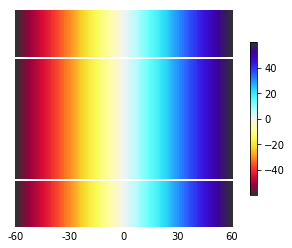

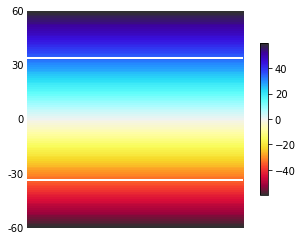

In [8]:
# Load colormap
cmap_name = 'nic_Edge'
zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=zero_center, 
                                                  return_cmap=True, dst_dir=curr_dst_dir)


# Process raw traces

In [9]:
#### Load raw and process traces -- returns average trace for condition
temporal_ds = float(RETID['PARAMS']['average_frames'])

#### Load raw and process traces -- returns average trace for condition
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
temporal_ds = float(RETID['PARAMS']['average_frames'])
np_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='neuropil')
soma_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='raw')

... loading traces (neuropil)
... loading traces (raw)


# Do FFT analysis

37 out of 238 cells pass mag-ratio thr (thr>=0.01)


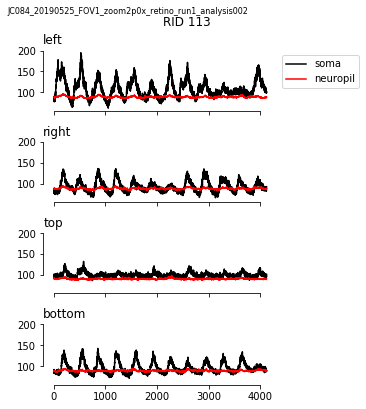

In [10]:
#### Get FFT params
n_frames = scaninfo['stimulus']['n_frames']
frame_rate = scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate)) # Label frequency bins
sorted_freq_idxs = np.argsort(freqs)

#### Do FFT
fft_soma = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in soma_traces.items())
fft_np = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in np_traces.items())

# Get magratios -- each column is a condition
magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
magratios_np = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_np.items()))

# Get phases
phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))
phases_np = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_np.items()))

# Get average across conditions
mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]

# Filter out bad cells
if all_conds_pass:
    roi_list = [i for i in magratios_soma.index if all(magratios_soma.loc[i] > mag_thr)]
else:
    roi_list = magratios_soma.index.tolist()
print("%i out of %i cells pass mag-ratio thr (thr>=%.2f)" % (len(roi_list), len(mean_magratio_values_soma), mag_thr))
sorted_by_mag = [r for r in sorted_rois_soma if r in roi_list]

# Look at example cell
if plot_examples:
    ret_utils.plot_some_example_traces(soma_traces, np_traces, plot_rois=sorted_rois_soma[0:3],
                         dst_dir=curr_dst_dir, data_id=data_id)
    

In [11]:
reload(ret_utils)

<module 'pipeline.python.retinotopy.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/utils.pyc'>

# Get mask info

In [12]:

# Get ROIID and projection image
masks_soma, masks_np, zimg = ret_utils.load_soma_and_np_masks(RETID)
roiid = RETID['PARAMS']['roi_id']
ds_factor = int(RETID['PARAMS']['downsample_factor'])
nrois_total, d1, d2 = masks_soma.shape

... FOV size: (256, 256) (downsample factor=2)


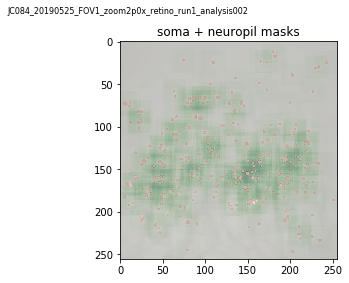

In [13]:
fig, ax = pl.subplots()
roi_utils.plot_neuropil_masks(masks_soma, masks_np, zimg, ax=ax)
ax.set_title('soma + neuropil masks')
label_figure(fig, data_id)
pl.savefig(os.path.join(curr_dst_dir, 'soma-v-neuropil-masks.png'))

# Dilate soma masks
From Liang et al., 2018, Cell.
1. Assign center of neuropil ring w/ preferred retino location.
2. From Neurpil ring center, dilate by a disk of 10um radius (20um diam)
3. Average overlapping disks
4. Spatially smooth w/ isotropic 2D Guassian filter (std=2um) for final pixe-wise estimates 

In [14]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [15]:
def dilate_mask_centers(maskcenters, kernel_size=9):
    '''Calculate center of soma, then dilate to create masks for smoothed  neuropil
    '''
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)

    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = (sum(x) / len(x), sum(y) / len(x))
        #print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks

def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    '''
    value_array: indices should be RIDs -- these ixs are used to index into masks.
    '''
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask



def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1,
                               is_circular=False, vmin=-np.pi, vmax=np.pi):
    '''
    value_array: indices should be RIDs -- these ixs are used to index into masks.
    '''
    
    nrois, d1, d2 = dilated_masks.shape
    
    # Get non-averaged array, shape=(d1, d2)
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    #print("no array:", tmpmask.shape, value_array.shape)
    
    # Get full array to average across overlapping pixels, shape=(nrois, d1, d2)?
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    #print("arr:", tmpmask_full.shape, value_array.shape)
    tmpmask_r = np.reshape(tmpmask_full, (nrois_total, d1*d2))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        if is_circular:
            avg_mask[ix] = spstats.circmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        else:
            avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1, d2))

    return avg_mask

In [16]:
# measured pixel size: (2.3, 1.9)
# want to dilate by ~9.52380952381

desired_radius_um = 10.0 #20.0

pixel_size = putils.get_pixel_size()
print(pixel_size)
um_per_pixel = np.mean(pixel_size) / ds_factor # divide by DS factor (pixels are half if ds=2)

pixels2dilate = desired_radius_um/um_per_pixel
#print(pixels2dilate)

(2.3, 1.9)


(9, 9)
Dilation diameter (um): 9.45
8
8


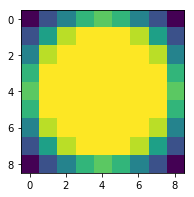

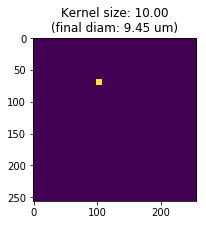

In [17]:
check_masks = True

# Set kernel params
kernel_size = np.ceil(pixels2dilate) #+2) #21
kernel_radius = (kernel_size - 1) // 2
x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

# Create three kernels for the sake of example
radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
# using ... allows compatibility with arbitrarily-shaped radius arrays
kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)
print(kernel.shape)


if check_masks:
    pl.figure(figsize=(3,3))
    pl.imshow(kernel)
    kernel_diam_um = (kernel.shape[0]*um_per_pixel)
    print("Dilation diameter (um): %.2f" % kernel_diam_um)

## Dilate all masks with kernel
dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

if check_masks:
    rid = 33
    pl.figure(figsize=(3,3))
    pl.imshow(dilated_masks[rid, :, :])
    pl.title("Kernel size: %.2f\n(final diam: %.2f um)" % (kernel_size, kernel_diam_um))
    x, y = np.where(dilated_masks[rid, :, :]>0)
    print x.max()-x.min()
    print y.max()-y.min()


# Assign phase to neuropil

In [19]:
def get_phase_masks(masks, phases, average_overlap=True, roi_list=None, use_cont=True, mask_thr=0.01):
    # Convert phase to continuous:
    phases_cont = -1 * phases
    phases_cont = phases_cont % (2*np.pi)
    
    # Only include specified rois:
    if roi_list is None:
        roi_list = phases.index.tolist()
        
    # Get absolute maps:
    if use_cont:
        elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
        azim = (phases_cont['left'] - phases_cont['right']) / 2.
        vmin = -np.pi
        vmax = np.pi
    else:
        # Get absolute maps:
        elev = (phases['bottom'] - phases['top']) / 2.
        azim = (phases['left'] - phases['right']) / 2.
        
        # Convert to continueous:
        elev_c = -1 * elev
        elev_c = elev_c % (2*np.pi)
        azim_c = -1 * azim
        azim_c = azim_c % (2*np.pi)

        vmin = 0
        vmax = 2*np.pi

        azim = copy.copy(azim_c)
        elev = copy.copy(elev_c)
        
    if average_overlap:
        azim_phase = mask_with_overlaps_averaged(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_with_overlaps_averaged(masks, elev[roi_list], mask_thr=mask_thr)
    else:
        azim_phase = mask_rois(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_rois(masks, elev[roi_list], mask_thr=mask_thr)   
    
    return azim_phase, elev_phase



In [20]:
use_cont = True
average_overlap = True
filter_by_mag = True
mask_thr=0.01

# Set bounds for averaging
vmin = -np.pi if use_cont else 0
vmax = np.pi if use_cont else 2*np.pi

# Assign phase value to dilated masks
azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, phases_np, average_overlap=average_overlap, 
                                               roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

azim_phase_soma, elev_phase_soma = get_phase_masks(masks_soma, phases_soma, average_overlap=average_overlap, 
                                                   roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

# Mask images for plotting
azim_phase_mask_np = np.ma.masked_where(azim_phase_np==-100, azim_phase_np)
elev_phase_mask_np = np.ma.masked_where(elev_phase_np==-100, elev_phase_np)

azim_phase_mask_soma = np.ma.masked_where(azim_phase_soma==-100, azim_phase_soma)
elev_phase_mask_soma = np.ma.masked_where(elev_phase_soma==-100, elev_phase_soma)


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


# Check resizing

#### Reshape array, if need

In [21]:
from pipeline.python.coregistration import align_fov as coreg

In [22]:
pixel_size = putils.get_pixel_size()
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)

((256, 256), (1177, 972))


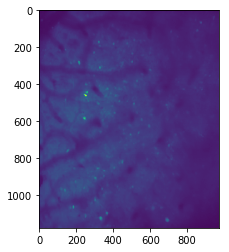

In [23]:
zimg_r = coreg.transform_2p_fov(zimg, pixel_size)
print(zimg.shape, zimg_r.shape)

pl.figure()
pl.imshow(zimg_r)

# Smooth

In [27]:
from scipy.interpolate import SmoothBivariateSpline

def fill_and_smooth_nans(img):

    y, x = np.meshgrid(np.arange(0, img.shape[1]), np.arange(0, img.shape[0]))
    x = x.astype(float)
    y = y.astype(float)
    z = img.copy()
    
    xx = x.copy()
    yy = y.copy()
    xx[np.isnan(z)] = np.nan
    yy[np.isnan(z)] = np.nan

    xx=xx.ravel()
    xx=(xx[~np.isnan(xx)])
    yy=yy.ravel()
    yy=(yy[~np.isnan(yy)])
    zz=z.ravel()
    zz=(zz[~np.isnan(zz)])

#     xnew = np.arange(xx.min(), xx.max()+1) #np.arange(9,11.5, 0.01)
#     ynew = np.arange(yy.min(), yy.max()+1) #np.arange(10.5,15, 0.01)

#     f = SmoothBivariateSpline(xx,yy,zz,kx=1,ky=1)
#     znew=np.transpose(f(xnew, ynew)).T

    xnew = np.arange(x.ravel().min(), x.ravel().max()+1) #np.arange(9,11.5, 0.01)
    ynew = np.arange(y.ravel().min(), y.ravel().max()+1) #np.arange(10.5,15, 0.01)
    
    #print(xnew.min(), xnew.max())
    
    f = SmoothBivariateSpline(xx,yy,zz,kx=1,ky=1)
    znew=f(xnew, ynew) #).T
    
    znew[np.isnan(z)] = np.nan
    
    #print(z.shape, znew.shape)
    return znew #.T #a


In [28]:
# Spatial smooth neuropil dilated masks 
smooth_fwhm = 7 #21
azim_smoothed = ret_utils.smooth_neuropil(azim_phase_np, smooth_fwhm=smooth_fwhm)
elev_smoothed = ret_utils.smooth_neuropil(elev_phase_np, smooth_fwhm=smooth_fwhm)

if 'zoom1p0x' in fov:
    print("... resizing")
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
    
azim_smoothed = fill_and_smooth_nans(azim_smoothed)
elev_smoothed = fill_and_smooth_nans(elev_smoothed)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_smoothed, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_smoothed, pixel_size, normalize=False)
print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())

az_fill = azim_r.copy()
el_fill = elev_r.copy()
# # Fill and smooth over NaNs
# az_fill = fill_and_smooth_nas(azim_r)
# el_fill = fill_and_smooth_nas(elev_r)



(-0.65341259777156147, 2.6868045370652096)


(u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure', 'soma-v-neuropil_dilate-center-10_spatial-smooth-7_circ_magthr-0.01')


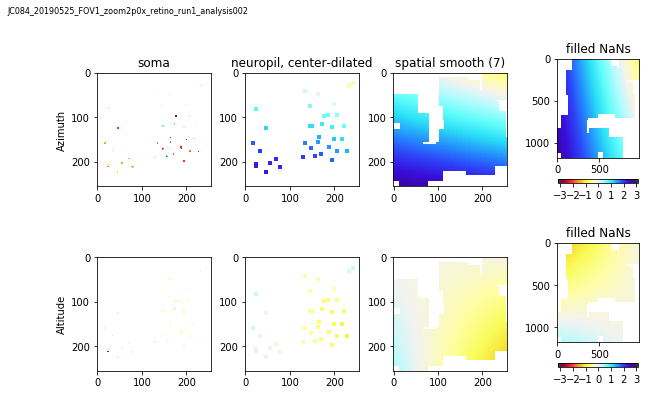

In [29]:
fig, axn = pl.subplots(2,4, figsize=(10,6))

ax = axn[0,0]
ax.imshow(azim_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('soma')
ax.set_ylabel('Azimuth')

ax = axn[0, 1]
ax.imshow(azim_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('neuropil, center-dilated')

ax = axn[0, 2]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 3]
im0 = ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)


ax = axn[1, 0]
ax.imshow(elev_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
#ax.set_title('soma')
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 3]
im1= ax.imshow(el_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im1, ax=ax, orientation='horizontal', shrink=0.7)

pl.subplots_adjust(wspace=0.3, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'soma-v-neuropil_dilate-center-%i_spatial-smooth-%i_circ_magthr-%.2f' % (kernel_size, smooth_fwhm, mag_thr)

#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

#### Plot smoothed azimuth neuropil

In [30]:
# cmap = 'nipy_spectral' # cmap_phase
# overlay = True
# overlay_str = '_overlay' if overlay else ''
# alpha = 0.5 if overlay else 1.0

# fig, axn = pl.subplots(1,2)
# ax = axn[0]
# if overlay:
#     ax.imshow(zimg_r, cmap='gray')
# ax.imshow(azim_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
# ax.set_title('Azimuth')

# ax = axn[1]
# if overlay:
#     ax.imshow(zimg_r, cmap='gray')
# ax.imshow(elev_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
# ax.set_title('Altitude')

# figname = 'smoothed_neuropil_dilate-%i_spatial-fwhm-%i%s' % (kernel_size, smooth_fwhm, overlay_str)

# pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


# Calculate image gradient

In [31]:
def calculate_gradients(img):
    # Get gradient
    gdy, gdx = np.gradient(img)
    
    # 3) Calculate the magnitude
    gradmag = np.sqrt(gdx**2 + gdy**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scale_factor = np.max(gradmag)/255
    #gradmag = (gradmag/scale_factor).astype(np.uint8)

    # 3) Take the absolute value of the x and y gradients
    abs_gdx = np.absolute(gdx)
    abs_gdy = np.absolute(gdy)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    abs_gd = np.arctan2(gdy, gdx) # np.arctan2(abs_gdy, abs_gdx) # [-pi, pi]

    # Get mean direction
    #mean_dir = np.rad2deg(np.arctan2(gdy.mean(), gdx.mean())) # TODO why this diff
#     mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())],
#                          low=-np.pi, high=np.pi)) # TODO why this diff
    mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())\
                                               if ((not np.isnan(gy)) and (not np.isnan(gx)))],
                         low=-np.pi, high=np.pi)) # TODO why this diff

    # Get unit vector
    avg_gradient = spstats.circmean(abs_gd[~np.isnan(abs_gd)], low=-np.pi, high=np.pi) #.mean()
    dirvec = (np.cos(avg_gradient), np.sin(avg_gradient))
    vhat = dirvec / np.linalg.norm(dirvec)

    grad_ = {'image': img,
             'magnitude': gradmag,
             'gradient_x': gdx,
             'gradient_y': gdy,
             'direction': abs_gd,
             'mean_deg': mean_dir, # DEG
             'mean_direction': avg_gradient, # RADIANS
             'vhat': vhat}
    
    return grad_


def plot_gradients(grad_, ax=None, draw_interval=3, scale=1, width=0.005, toy=False, headwidth=5):
    '''
    scale:  # of dat units per arrow length unit (smaller=longer arrow)
    scale_units 
    weight = width of plot
    angles='xy' (i.e., arrows point from (x,y) to (x+u, y+v))
    Arrows should point TOWARD larger numbers
    '''
    if ax is None:
        fig, ax = pl.subplots()
        
    gradimg = grad_['image']
    mean_dir = grad_['mean_deg']
    gdx = grad_['gradient_x']
    gdy = grad_['gradient_y']
    
    # Set limits and number of points in grid
    y, x = np.mgrid[0:gradimg.shape[0], 0:gradimg.shape[1]]

    # Every 3rd point in each direction.
    skip = (slice(None, None, draw_interval), slice(None, None, draw_interval))
    
    # plot
    ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], color='k',
              scale=scale, width=width,
              scale_units='xy', angles='xy', pivot='mid', units='width',
              headwidth=headwidth)
    
    gdir_ = grad_['direction'].copy()
    gmean = spstats.circmean(gdir_[~np.isnan(gdir_)], low=-np.pi, high=np.pi)
    
    avg_dir_grad = np.rad2deg(gmean) #np.nanmean(grad_['direction']))
    
    ax.set(aspect=1, title="Mean: %.2f\n(dir: %.2f)" % (mean_dir, avg_dir_grad))

    return ax

#### Test w/ toy example

In [32]:
# Create some images going in various directions
gradimg = np.ones((60, 30))
for i in range(30):
    gradimg[:, i] = gradimg[:, i]*(i**2)*0.01
gradimg = gradimg.astype(float)
gradimg_lr = np.fliplr(gradimg.copy()) #gradimg.T
gradimg_ud = gradimg.copy().T
gradimg_du = np.flipud(gradimg_ud)

# Calculate gradients
grad_ = calculate_gradients(gradimg)
grad_lr = calculate_gradients(gradimg_lr)
grad_ud = calculate_gradients(gradimg_ud)
grad_du = calculate_gradients(gradimg_du)


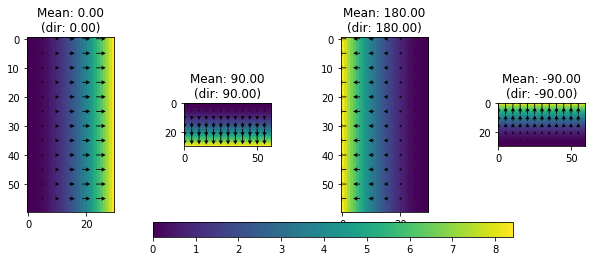

In [33]:
# Yellow = higher #s, arrows should point in direction toward higher
spacing = 5
scale=None
width=0.01
headwidth=5

fig, axn = pl.subplots(1,4, figsize=(10, 4))
cbar_ax = fig.add_axes([0.3, 0.15, 0.5, 0.05])

ax = axn[0]
ax.imshow(grad_['image'])
plot_gradients(grad_, ax=ax,draw_interval=spacing, toy=True, 
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[1]
ax.imshow(grad_ud['image'])
plot_gradients(grad_ud, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[2]
ax.imshow(grad_lr['image'])
plot_gradients(grad_lr, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[3]
im = ax.imshow(grad_du['image'])
plot_gradients(grad_du, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

pl.subplots_adjust(wspace=0.8)
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
pl.subplots_adjust(bottom=0.2)
pl.savefig(os.path.join(curr_dst_dir, 'test_gradient_dirs.png'))

## Test calculation of slope with toy ex

In [34]:
gimg = grad_['image'].copy()
d1, d2 = grad_['image'].shape
print(d1, d2)
vhat_ = grad_['vhat']

# gimg = grad_az['image'].copy()
# d1, d2 = grad_az['image'].shape
# print(d1, d2)
# vhat_ = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))

(60, 30)


('shape:', (60, 30))


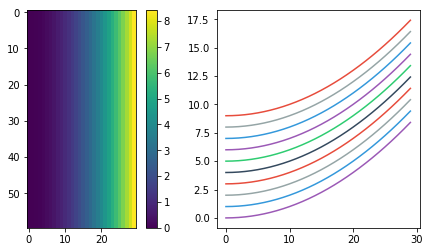

In [35]:
fig, axn =pl.subplots(1,2, figsize=(8,4))
i0 = axn[0].imshow(gimg)
pl.colorbar(i0, ax=axn[0])
print("shape:", gimg.shape)
ax=axn[1]

n=10
for i in np.arange(0, n):
    axn[1].plot(gimg[i,:] + i)

#### Project and test

In [36]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])

ret_az = np.array([gimg[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])

In [37]:
n=60
for c, i, v in zip(coords[0:n], proj_az[0:n], ret_az[0:n]):
    print('[%i, %i] %.2f, %.2f' % (c[0], c[1], i,v))
    
print('--------last few:')
print(coords[-5:])

[0, 0] 0.00, 0.00
[1, 0] 1.00, 0.01
[2, 0] 2.00, 0.04
[3, 0] 3.00, 0.09
[4, 0] 4.00, 0.16
[5, 0] 5.00, 0.25
[6, 0] 6.00, 0.36
[7, 0] 7.00, 0.49
[8, 0] 8.00, 0.64
[9, 0] 9.00, 0.81
[10, 0] 10.00, 1.00
[11, 0] 11.00, 1.21
[12, 0] 12.00, 1.44
[13, 0] 13.00, 1.69
[14, 0] 14.00, 1.96
[15, 0] 15.00, 2.25
[16, 0] 16.00, 2.56
[17, 0] 17.00, 2.89
[18, 0] 18.00, 3.24
[19, 0] 19.00, 3.61
[20, 0] 20.00, 4.00
[21, 0] 21.00, 4.41
[22, 0] 22.00, 4.84
[23, 0] 23.00, 5.29
[24, 0] 24.00, 5.76
[25, 0] 25.00, 6.25
[26, 0] 26.00, 6.76
[27, 0] 27.00, 7.29
[28, 0] 28.00, 7.84
[29, 0] 29.00, 8.41
[0, 1] 0.00, 0.00
[1, 1] 1.00, 0.01
[2, 1] 2.00, 0.04
[3, 1] 3.00, 0.09
[4, 1] 4.00, 0.16
[5, 1] 5.00, 0.25
[6, 1] 6.00, 0.36
[7, 1] 7.00, 0.49
[8, 1] 8.00, 0.64
[9, 1] 9.00, 0.81
[10, 1] 10.00, 1.00
[11, 1] 11.00, 1.21
[12, 1] 12.00, 1.44
[13, 1] 13.00, 1.69
[14, 1] 14.00, 1.96
[15, 1] 15.00, 2.25
[16, 1] 16.00, 2.56
[17, 1] 17.00, 2.89
[18, 1] 18.00, 3.24
[19, 1] 19.00, 3.61
[20, 1] 20.00, 4.00
[21, 1] 21.00, 4.41


#### plot results

Text(0,0.5,u'retino')

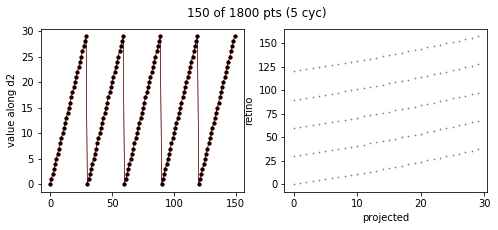

In [38]:
fig, axn = pl.subplots(1,2, figsize=(8,3)) #.figure()

ncyc=5
npts = d2*ncyc
fig.suptitle("%i of %i pts (%i cyc)" % (npts, len(proj_az), ncyc))

ax = axn[0]
ax.plot(proj_az[0:npts], 'r',  marker='.', lw=0.5)
ax.plot(pix[0:npts], 'k',  marker='.', lw=.5)
#ax.plot(ret_az[0:npts], 'b', marker='.', lw=0)
ax.set_ylabel('value along d2')
ax = axn[1]
offsets = [i for i in np.arange(0, npts)]
ax.scatter(proj_az[0:npts], ret_az[0:npts]+offsets, marker='.', s=2)
ax.set_xlabel('projected')
ax.set_ylabel('retino')

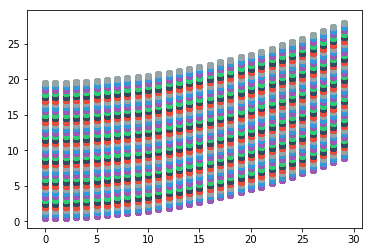

In [105]:
pl.figure()
ncyc=40
#pl.scatter(proj_az[0:d2*ncyc], ret_az[0:d2*ncyc])
for i in np.arange(1, ncyc):
    pl.scatter(proj_az[0:d2*ncyc], ret_az[0:d2*ncyc]+i*0.5)

## Calculate gradient on retino map

In [39]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [40]:
# Calculate gradients
plot_degrees = True

if plot_degrees:
    vmin=-np.pi
    vmax=np.pi
    img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, 
                           newmin=screen_min, newmax=screen_max)
    img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax,
                           newmin=screen_min, newmax=screen_max)
    
    grad_az = calculate_gradients(img_az)
    grad_el = calculate_gradients(img_el)
    vmin, vmax = (screen_min, screen_max)

else:
    grad_az = calculate_gradients(az_fill)
    grad_el = calculate_gradients(el_fill)
    vmin, vmax = (-np.pi, np.pi)
    
print(vmin, vmax)

(-59.7782, 59.7782)


In [41]:
#plot_degrees = True

if not plot_degrees:
    img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, 
                           newmin=screen_min, newmax=screen_max)
    img_el = convert_range(el_fille, oldmin=vmin, oldmax=vmax,
                           newmin=screen_min, newmax=screen_max)
    vmin, vmax = (screen_min, screen_max)


(u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure', 'gradients_dilate-center-10_spatial-smooth-7_degrees_circ_magthr-0.01')


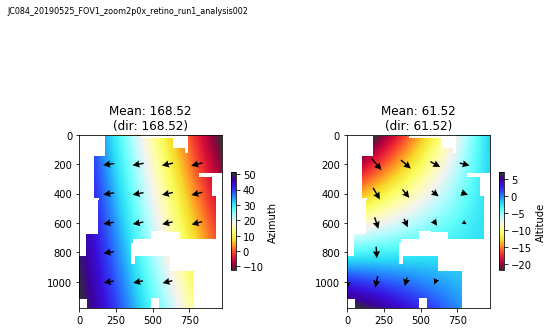

In [46]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''
fig, axn = pl.subplots(1, 2, figsize=(8,6))
ax = axn[0]
im = ax.imshow(img_az, cmap=cmap_phase)#, vmin=vmin, vmax=vmax)
plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Azimuth')

ax = axn[1]
im = ax.imshow(img_el,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Altitude')

pl.subplots_adjust(wspace=0.5, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'gradients_dilate-center-%i_spatial-smooth-%i_%s_circ_magthr-%.2f' % (kernel_size, smooth_fwhm, plot_str, mag_thr)

pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [171]:
grad_az.keys()

['direction',
 'magnitude',
 'image',
 'mean_direction',
 'vhat',
 'mean_deg',
 'gradient_y',
 'gradient_x']

## Compute unit vector and project

In [47]:

avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL]avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ]avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

print(vhat_az, vhat_el)


[EL]avg dir: 61.52 deg
[AZ]avg dir: 168.52 deg
(array([-0.98000305,  0.19898248]), array([ 0.47677851,  0.87902346]))


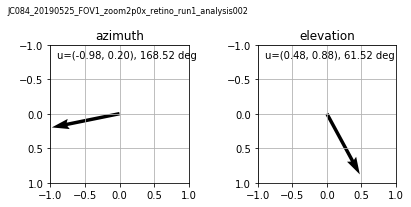

In [48]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))

ax = axn[0]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))

ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
figname = 'gradients__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.2f' % (kernel_size, smooth_fwhm, plot_str, mag_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


#### Test vector directions an quiver plotting...

(1, 1)


Text(1.24254,1.97014,u'unit')

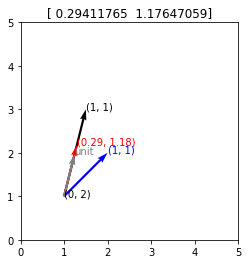

In [49]:

# for xi in np.arange(0, 3):
#     for yi in np.arange(0, 5):

y, x = np.mgrid[0:gimg.shape[0], 0:gimg.shape[1]]

xi=1
yi=1

fig, ax =pl.subplots()
ax.set_aspect('equal')
ax.set_ylim([0, 5])
ax.set_xlim([0, 5])
print(x[xi, yi], y[xi, yi])

v1 = np.array([0.5, 2.0])
v2 = np.array([1.0, 1.0])
vh = v1 / np.linalg.norm(v1) # unit vector

# Original vector, direction
ax.quiver(x[xi, yi], y[xi, yi], v1[0], v1[1], color='k', 
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+v1[0], y[xi, yi]+v1[1], '(%i, %i)' % (x[xi, yi], y[xi, yi]))
ax.text(x[xi, yi], y[xi, yi], '(%i, %i)' % (v1[0], v1[1]))

# V to be projected
ax.quiver(x[xi, yi], y[xi, yi], v2[0], v2[1], color='b',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+v2[0], y[xi, yi]+v2[1], '(%i, %i)' % ( v2[0], v2[1]), color='b')

# vec projection onto original
vproj = vh * np.dot(v2, vh) 
ax.quiver(x[xi, yi], y[xi, yi], vproj[0], vproj[1], color='r',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+vproj[0], y[xi, yi]+vproj[1], '(%.2f, %.2f)' % (vproj[0], vproj[1]), color='r')
ax.set_title(vproj)

# Also show unit
ax.quiver(x[xi, yi], y[xi, yi], vh[0], vh[1], color='gray',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+vh[0], y[xi, yi]+vh[1], 'unit', color='gray')# % (x[xi, yi], y[xi, yi]))


## Calculate gradients and projec to get mean

In [50]:
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/evaluate_receptivefield_fits.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_in

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/matplotlib/quiver.py:666: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/matplotlib/quiver.py:666: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


(u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_9bb068/retino-structure', 'vhat_gradients_10_spatial-smooth-7_azimuth')


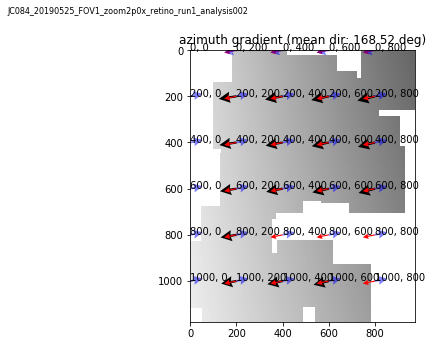

In [51]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5


condition = 'azimuth'

# Set limits and number of points in grid
if condition == 'azimuth':
    gimg = grad_az['image'].copy()
    vhat = grad_az['vhat']
    gdx = grad_az['gradient_x']
    gdy = grad_az['gradient_y']
    mean_dir = np.rad2deg(grad_az['mean_direction'])

elif condition == 'elevation':
    gimg = grad_el['image'].copy()
    vhat = grad_el['vhat']
    gdx = grad_el['gradient_x']
    gdy = grad_el['gradient_y']
    mean_dir = np.rad2deg(grad_el['mean_direction'])

# Every 3rd point in each direction.
y, x = np.mgrid[0:gimg.shape[0], 0:gimg.shape[1]]
skip = (slice(None, None, spacing), slice(None, None, spacing))

# Plot image
fig, ax = pl.subplots(figsize=(8,5))
ax.imshow(gimg, vmin=vmin, vmax=vmax, cmap='gray') # #, origin='top')
ax.set(aspect=1, title='%s gradient (mean dir: %.2f deg)' % (condition, mean_dir))


# Plot all the gradients
ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], 
          color='k', scale=scale, width=width, headwidth=headwidth,
          scale_units='xy', units='width', angles='xy', pivot='tail')

# Plot unit vector at each position
ax.quiver(x[skip], y[skip], vhat[0], vhat[1], #np.array((vhat_el[1])), 
              #color='r', alpha=1, width=0.005,
              color='r', scale=scale, width=0.005, headwidth=headwidth,
              scale_units='xy', units='width', angles='xy', pivot='tail')

for xi, xv in enumerate(np.arange(0, y.shape[0], spacing)):
    for yi, yv in enumerate(np.arange(0, y.shape[1], spacing)):
        #nv = (gdx[skip][xi, yi], gdy[skip][xi, yi])
        nv = np.array([y[skip][xi, yi], x[skip][xi, yi]])
        #print(xi, yi, nv)
        # vector projection onto vhat (multiply with unit vec in direction of dirvec)
        vproj = vhat * np.dot(nv, vhat) 
        ax.text(x[skip][xi, yi], y[skip][xi, yi], '%i, %i' %(xv, yv), fontsize=10)
        
        # Plot projection
        ax.quiver(x[skip][xi, yi], 
                  y[skip][xi, yi], 
                  vproj[0], vproj[1],
                  alpha=0.5, #width=0.008,
                  color='b', scale=scale, width=0.008, headwidth=headwidth,
                  scale_units='xy', units='width', angles='xy', pivot='tail')


putils.label_figure(fig, data_id)
figname = 'vhat_gradients_%i_spatial-smooth-%i_%s' % (kernel_size, smooth_fwhm, condition)

pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)


# Project coordinates onto "prevailing" retino dir

In [52]:
gimg_az = grad_az['image'].copy()
d1, d2 = grad_az['image'].shape
print(d1, d2)
vhat_az = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
vhat_el = grad_el['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
print(vhat_az, vhat_el)

gimg_el = grad_el['image'].copy()


(1177, 972)
(array([-0.98000305,  0.19898248]), array([ 0.47677851,  0.87902346]))


In [53]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])


In [54]:
proj_el.max()

1496.683529539119

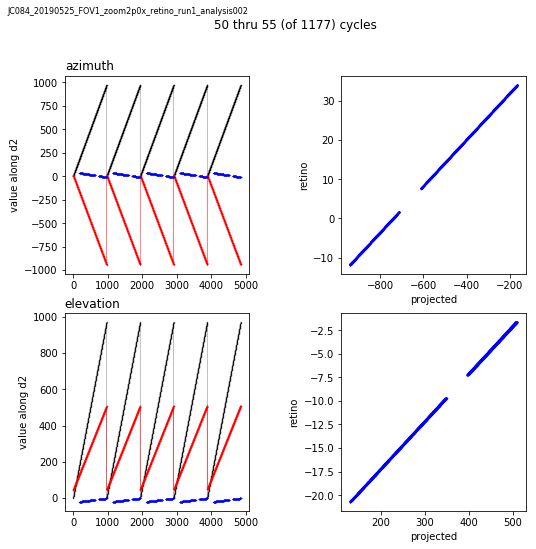

In [55]:
fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()

ncyc=5

startcyc=50
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.set_title('azimuth', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b', marker='.', lw=0, markersize=0.5)
ax.set_ylabel('value along d2')

ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.set_title('elevation', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_el[spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
figname = 'test_projections__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.2f' % (kernel_size, smooth_fwhm, plot_str, mag_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


## Fit linear

In [58]:
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics

In [124]:
# reload(evalrf)

<module 'pipeline.python.classifications.evaluate_receptivefield_fits' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/evaluate_receptivefield_fits.py'>

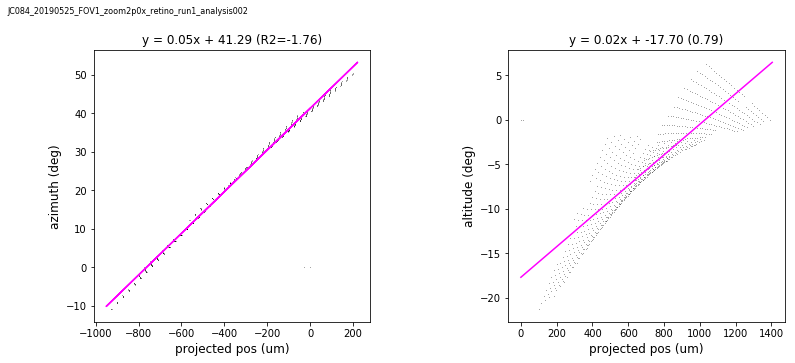

In [59]:
fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], return_regr=True)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], return_regr=True)

# rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
# r2 = skmetrics.r2_score(yv, fitv)
# pearson_p, pearson_r = spstats.pearsonr(xv, yv)

fig, axn = pl.subplots(1,2, figsize=(12, 5))
spacing=1000
ax=axn[0]
#sns.regplot(proj_az, ret_az, ax=ax, scatter=False, color='k')
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az, color='magenta')
r2_az = skmetrics.r2_score(proj_az[~np.isnan(ret_az)], fitv_az)
linfit_str = 'y = %.2fx + %.2f (R2=%.2f)' % (float(regr_az.coef_), float(regr_az.intercept_), r2_az) 
ax.set_title(linfit_str)
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
#sns.regplot(proj_el, ret_el, ax=ax, scatter=False, color='k')
ax.scatter(proj_el[0::spacing], ret_el[0::spacing], marker='.', lw=0, color='k', s=1)
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el, color='magenta')
r2_el = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el)
linfit_str = 'y = %.2fx + %.2f (%.2f)' % (float(regr_el.coef_), float(regr_el.intercept_), r2_el) 
ax.set_title(linfit_str)
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
figname = 'Proj_versus_Retinopos__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.2f' % (kernel_size, smooth_fwhm, plot_str, mag_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


NameError: name 'datakey' is not defined

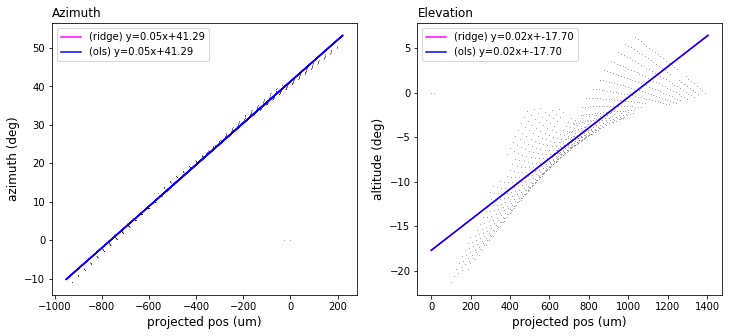

In [60]:
regr_model = 'ridge'
regr_line_color = 'magenta'
regr_model2 = 'ols' 

fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

fitv_az2, regr_az2 = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model2)
fitv_el2, regr_el2 = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model2)

# rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
# r2 = skmetrics.r2_score(yv, fitv)
# pearson_p, pearson_r = spstats.pearsonr(xv, yv)

fig, axn = pl.subplots(1,2, figsize=(12, 5))
spacing=1000
ax=axn[0]
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)

linfit_str = '(%s) y=%.2fx+%.2f' % (regr_model, float(regr_az.coef_), float(regr_az.intercept_)) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az, color=regr_line_color, label=linfit_str)

linfit_str2 = '(%s) y=%.2fx+%.2f' % (regr_model2, float(regr_az2.coef_), float(regr_az2.intercept_)) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Azimuth', loc='left')
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
#sns.regplot(proj_el, ret_el, ax=ax, scatter=False, color='k')
ax.scatter(proj_el[0::spacing], ret_el[0::spacing], marker='.', lw=0, color='k', s=1)

linfit_str = '(%s) y=%.2fx+%.2f' % (regr_model, float(regr_el.coef_), float(regr_el.intercept_)) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el, color=regr_line_color, label=linfit_str)

linfit_str2 = '(%s) y=%.2fx+%.2f' % (regr_model2, float(regr_el2.coef_), float(regr_el2.intercept_)) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Elevation', loc='left')
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

label_figure(fig, '%s_%s' % (data_id, datakey))

pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'Proj_versus_Retinopos__dilate-center-%i_spatial-smooth-%i_%s' % (kernel_size, smooth_fwhm, plot_str)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [767]:
datakey

'20190607_JC091_fov1'

# Test loading projection results
This is output of classifications/aggregate_gradient_estimates()

In [61]:
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import train_test_split
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

import seaborn as sns

In [62]:

def get_retino_metadata(experiment='retino', animalids=None,
                        roi_type='manual2D_circle', traceid=None,
                        rootdir='/n/coxfs01/2p-data', 
                        aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):

    sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
   
    meta_list=[]
    for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
        if animalids is not None:
            if animalid not in animalids:
                continue
        exp_list = [e for e in g['experiment'].values if experiment in e] 
        if len(exp_list)==0:
            print('skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % experiment,
                                'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retino_run = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                rid_fpath = glob.glob(os.path.join(retino_dir, 'analysisids_*.json'))[0]
                with open(rid_fpath, 'r') as f:
                    retids = json.load(f)
                traceids = [r for r, res in retids.items() if res['PARAMS']['roi_type']==roi_type] 
                for traceid in traceids: 
                    meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))
            else:
                meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))

    return meta_list



## Some aggregate plotting stuff

In [63]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

## Load data

In [64]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

filter_by='drop_repeats'

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)

In [65]:
data_id = 'retinobar|%s|%s|%s' % (state, fov_type, fit_desc)
print(data_id)

retinobar|awake|zoom2p0x|fit-2dgaus_dff-no-cutoff


In [66]:
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
retdata = sdata[sdata['experiment']=='retino'].copy()

In [67]:
retdata.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,23,23,23,23,23
Lm,19,19,19,19,19
V1,15,15,15,15,15


In [68]:
meta_list = get_retino_metadata(experiment='retino', traceid=traceid)

proj_fit_paths=[]; errors=[];
for (animalid, session, fov, retinorun, _) in meta_list:
    # Load data metainfo
    run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
    RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
    analysis_dir = RETID['DST']
    retinoid = RETID['analysis_id']
    #print("Loaded: %s, %s (%s))" % (retinorun, retinoid, run_dir))
    #retino_meta.append((animalid, session, fov, retinorun, retinoid))
    
    datakey = '_'.join([session, animalid, fov, retinorun])
    try:
        fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun,
                                                'retino_analysis', '%s*' % retinoid, 
                                                'retino-structure', 'projection_results.pkl'))
        assert len(fpaths)==1, "[%s] %i paths found" % (datakey, len(fpaths))
    except Exception as e:
        errors.append(datakey)
        continue
    proj_fit_paths.append((animalid, session, fov, retinorun, retinoid, fpaths[0]))
print("%i of %i paths found" % (len(proj_fit_paths), len(meta_list)))

skipping, no retino (JC076, 20190502, FOV1_zoom2p0x)
skipping, no retino (JC091, 20191007, FOV1_zoom2p0x)
skipping, no retino (JC092, 20190527, FOV2_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV1_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV3_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV1_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV4_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV3_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV4_zoom2p0x)
56 of 60 paths found


In [699]:
# Create dir to copy gradient images to, for visual inspection
copy_images = True

shu

dst = os.path.join(aggr_retino_dir, 'gradient_analysis', 'by_session')
if not os.path.exists(dst):
    os.makedirs(dst)

In [724]:
d_list=[]
for (animalid, session, fov, retinorun, retinoid, fpath) in proj_fit_paths:
    fovnum = int(fov.split('_')[0][3:])
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    with open(fpath, 'rb') as f:
        res = pkl.load(f)
    
    tmpd = res['regr_df'].copy()
    tmpd['animalid'] = [animalid for _ in np.arange(0, tmpd.shape[0])]
    tmpd['session'] = [session for _ in np.arange(0, tmpd.shape[0])]
    tmpd['fov'] = [fov for _ in np.arange(0, tmpd.shape[0])]
    tmpd['retinorun'] = [retinorun for _ in np.arange(0, tmpd.shape[0])]
    tmpd['retinoid'] = [retinoid for _ in np.arange(0, tmpd.shape[0])]
    tmpd['datakey'] = [datakey for _ in np.arange(0, tmpd.shape[0])]
    tmpd['fpath'] = [fpath for _ in np.arange(0, tmpd.shape[0])]
    visual_area = retdata[(retdata['animalid']==animalid) 
                          & (retdata['session']==session) 
                          & (retdata['fov']==fov)]['visual_area'].values
    assert len(visual_area)==1, "[%s] Unknown visual area: %s" % (datakey, str(visual_area))
    tmpd['visual_area'] = [visual_area[0] for _ in np.arange(0, tmpd.shape[0])]
    d_list.append(tmpd)

    if copy_images:
        src = os.path.split(fpath)[0]
        fimpaths = glob.glob(os.path.join(src, 'gradient*.svg'))
        for fimpath in fimpaths:
            fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
            #print(fname, fext)
            shutil.copyfile(fimpath, os.path.join(dst, '%s_%s_%s_%s%s' % (visual_area[0], datakey, retinorun, fname, fext)))
projection_df = pd.concat(d_list, axis=0)

projection_df['abs_coef'] = abs(projection_df['coefficient'])
print(projection_df.shape)
projection_df.head()

(112, 16)


,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,fpath,visual_area,abs_coef
0,0.521641,5.036027,-0.028772,az,8.379515,0.0,-0.722247,JC076,20190422,FOV1_zoom2p0x,retino_run1,analysis002,20190422_JC076_fov1,/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0...,Li,0.028772
1,0.574736,1.195232,-0.004146,el,6.781446,0.0,-0.758113,JC076,20190422,FOV1_zoom2p0x,retino_run1,analysis002,20190422_JC076_fov1,/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0...,Li,0.004146
0,0.376911,5.669902,0.023068,az,17.792641,0.0,0.613931,JC076,20190501,FOV1_zoom2p0x,retino_run1,analysis002,20190501_JC076_fov1,/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0...,V1,0.023068
1,0.935464,1.673006,0.019008,el,-16.516685,0.0,0.967194,JC076,20190501,FOV1_zoom2p0x,retino_run1,analysis002,20190501_JC076_fov1,/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0...,V1,0.019008
0,0.980055,2.919857,-0.072586,az,47.694320,0.0,-0.989977,JC078,20190430,FOV1_zoom2p0x,retino_run1,analysis002,20190430_JC078_fov1,/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0...,Lm,0.072586


In [621]:
# Load 1 fov to test sth
fpath = [p for p in proj_fit_paths if p[0]=='JC084' and p[1]=='20190522' and p[3]=='retino_run1'][0][5]

with open(fpath, 'rb') as f:
    res = pkl.load(f)
    
print(res['regr_az'].coef_, res['regr_az'].intercept_)

res['regr_df']

(array([[ 0.01911469]]), array([ 6.46143726]))


,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r
0,0.915193,1.467429,0.019115,az,6.461437,0.0,0.956657
1,0.814970,1.261910,0.008356,el,-21.107253,0.0,0.902757


In [624]:

grad_fpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(grad_fpath, 'rb') as f:
    gresults = pkl.load(f)
gresults.keys()


['el', 'az']

In [626]:
gresults['el']['vhat']

array([ 0.63916915,  0.76906618])

In [471]:
projdf['coefficient'].min()

-0.087591987093163681

## Select fovs with good gradient fits (R2 threshold)
"Bad" fits suggests that the retino gradient was messed up or points were all over the place?

In [69]:
r2_thr=0.5

In [701]:
r2_thr=0.5

# Select FOVs with BOTH azimuth and elevation passed
projdf = pd.concat([g for (datakey, retinorun), g in projection_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) and (g[g['cond']=='el']['R2'].values > r2_thr))])
projdf['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun in projdf[['datakey', 'retinorun']].values]
print(projection_df.shape, projdf.shape)


((112, 15), (70, 16))


In [588]:
# sns.catplot(x='visual_area', y='abs_coef', col='cond', hue='visual_area', data=passdf,
#           palette=area_colors, order=visual_areas)

### Look pairwise by FOV (how consistent is this trend)  

In [74]:
fit_str = 'R2-%.2f' % r2_thr


V1: (t-stat:4.42, p=0.00)
Lm: (t-stat:5.53, p=0.00)
Li: (t-stat:6.71, p=0.00)
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'rate_of_retino_change_R2-0.50')


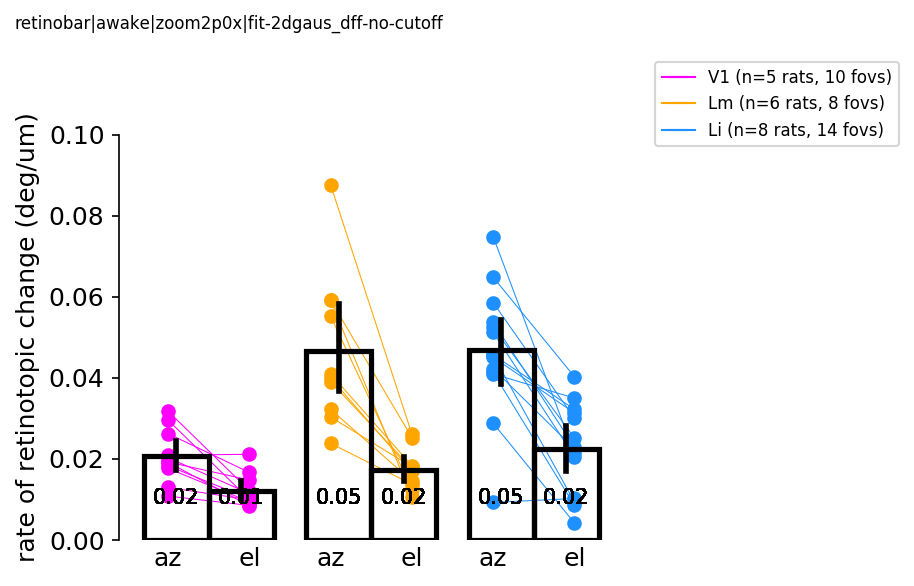

In [702]:
fit_str = 'R2-%.2f' % r2_thr

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax = rfutils.pairwise_compare_single_metric(projdf, curr_metric='abs_coef', ax=ax,
                                            c1='az', c2='el', compare_var='cond')
projdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10)
    
# Set x labels
rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
ax.set_ylabel('rate of retinotopic change (deg/um)', fontsize=12)

pl.subplots_adjust(left=0.15, right=0.8, top=0.8)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(projdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.6,1.2), fontsize=8)

ax.set_ylim([0, 0.1])
figname = 'rate_of_retino_change_%s' % (fit_str)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis', '%s.svg' % figname))

print(aggr_retino_dir, figname)

# Compare RF fits with retino gradient

In [70]:
from pipeline.python.rois.utils import load_roi_coords

In [71]:
def get_rf_dataframe(filter_by=None, fit_thr=0.5, traceid='traces001',
                    fit_desc='fit-2dgaus_dff-no-cutoff', fov_type='zoom2p0x',
                    state='awake', stimulus='rfs', verbose=False):
    
    #### Get non-repeated FOV datasets
    r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                      traceid=traceid, fit_desc=fit_desc,
                                                      reliable_only=reliable_only, verbose=verbose,
                                                      fov_type=fov_type, state=state, stimulus=stimulus)

    #### Split fx, fy for theta comp
    r_df['fx'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.cos(r_df['theta']))
    r_df['fy'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.sin(r_df['theta']))
    r_df['ratio_xy'] = r_df['std_x']/r_df['std_y']

    # Convert thetas to [-90, 90]
    thetas = [(t % np.pi) - np.pi if ((np.pi/2.)<t<(np.pi) or (((3./2)*np.pi)<t<2*np.pi)) \
              else (t % np.pi) for t in r_df['theta'].values]
    r_df['theta_c'] = thetas

    return r_df

In [72]:
def abline(slope, intercept, ax=None, color='purple', ls='-',
           label=True, label_prefix=''):
    """Plot a line from slope and intercept"""
    if ax is None:
        fig, ax = pl.subplots()
    #axes = plt.gca()
    #x_vals = np.array(axes.get_xlim())
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    label_str = '(%s) y=%.2fx+%.2f' % (label_prefix, slope, intercept) if label else None
    ax.plot(x_vals, y_vals, '--', label=label_str, color=color, ls=ls)
    ax.legend()
    return ax

### Select RF dataset filters

In [75]:
scale_sigma = False
reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

filter_str = '%s_%s_retinog%s' % (filter_by, reliable_str, fit_str)
print(filter_str)


drop_repeats_reliable_retinogR2-0.50


### Get cell positions (and RF info)

In [76]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(aggr_rf_dir):
    os.makedirs(aggr_rf_dir)
print("... saving output to base dir:\n%s" % aggr_rf_dir)


... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [77]:
#df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s_r_df.pkl' % (filter_by, reliable_str))
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_r_df.pkl


In [78]:
get_positions = False
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            r_df = pkl.load(f)
    except Exception as e:
        get_positions = True
print(get_positions)

Loading existing RF coord conversions...
False


In [79]:
if get_positions:
    # Get RF fit info first
    r_df = get_rf_dataframe(filter_by=filter_by, reliable_only=reliable_only,
                     fit_thr=fit_thr, traceid=traceid, fit_desc=fit_desc,
                    verbose=False, fov_type=fov_type, state=state, stimulus='rfs')
    
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        r_df[p] = ''
    
    # Add fov coord info and save
    p_list=[]
    for (animalid, session, fovnum, exp), g in r_df.groupby(['animalid', 'session', 'fovnum', 'experiment']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            r_df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(r_df, f, protocol=pkl.HIGHEST_PROTOCOL)

In [717]:
no_retino=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    if (projdf[projdf['datakey']==datakey].shape[0])==0:
        no_retino.append((visual_area, datakey))
for r in no_retino:
    print r
    

('Li', '20190502_JC076_fov1')
('Li', '20190527_JC092_fov2')
('Li', '20190527_JC092_fov3')
('Li', '20190528_JC092_fov1')
('Li', '20190605_JC090_fov1')
('Li', '20190617_JC099_fov1')
('Li', '20191007_JC091_fov1')
('Li', '20191008_JC091_fov1')
('Li', '20191105_JC117_fov1')
('Lm', '20190423_JC076_fov1')
('Lm', '20190513_JC078_fov1')
('Lm', '20190602_JC080_fov2')
('Lm', '20190603_JC080_fov1')
('Lm', '20190627_JC091_fov1')
('Lm', '20191004_JC110_fov4')
('Lm', '20191012_JC113_fov3')
('Lm', '20191104_JC117_fov2')
('Lm', '20191106_JC120_fov4')
('Lm', '20191111_JC117_fov2')
('V1', '20190420_JC076_fov1')
('V1', '20190622_JC085_fov1')
('V1', '20191106_JC120_fov3')


In [723]:
r_df.columns

Index([u'r2', u'fwhm_x', u'fwhm_y', u'theta', u'x0', u'y0', u'animalid',
       u'cell', u'datakey', u'experiment', u'fovnum', u'session',
       u'visual_area', u'std_x', u'std_y', u'fwhm_avg', u'std_avg', u'area',
       u'datakey_ix', u'fx', u'fy', u'ratio_xy', u'theta_c', u'fov_xpos',
       u'fov_xpos_pix', u'fov_ypos', u'fov_ypos_pix', u'ml_pos', u'ap_pos'],
      dtype='object')

In [739]:
p_df = projection_df[projection_df['datakey']==datakey]
p_df

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,fpath,visual_area,abs_coef
0,0.982065,2.666692,0.064817,az,-52.074422,0.0,0.990992,JC120,20191111,FOV1_zoom2p0x,retino_run1,analysis002,20191111_JC120_fov1,/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0...,Li,0.064817
1,0.708902,4.999678,-0.040259,el,0.285559,0.0,-0.841963,JC120,20191111,FOV1_zoom2p0x,retino_run1,analysis002,20191111_JC120_fov1,/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0...,Li,0.040259


In [741]:
    p_df[p_df['retinorun']==retinorun]['fpath'].unique()[0]


u'/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_6a8366/retino-structure/projection_results.pkl'

In [743]:
rd

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,fx,fy,ratio_xy,theta_c,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
447,0.917663,30.707761,37.559167,0.503039,-1.644652,0.937623,JC120,66,20191111_JC120_fov1,rfs10,...,14.002722,7.705067,0.817584,0.503039,341.066,148,647.264,340,325.536,836.534
448,0.698990,30.621318,22.591748,6.133987,20.996492,-9.180793,JC120,75,20191111_JC120_fov1,rfs10,...,12.885588,1.936903,1.355420,-0.149198,246.582,107,435.951,229,536.849,931.018
449,0.555461,39.728106,18.565845,0.869611,-39.634763,15.373389,JC120,84,20191111_JC120_fov1,rfs10,...,10.906195,12.917177,2.139849,0.869611,283.454,123,812.888,427,159.912,894.146
450,0.586550,35.009019,19.971496,0.216169,14.644072,1.992880,JC120,183,20191111_JC120_fov1,rfs10,...,14.550737,3.195341,1.752949,0.216169,193.578,84,508.293,267,464.507,984.022


In [ ]:
d_list=[]
for (datakey, animalid, session, fovnum, exp), rd in r_df.groupby(['datakey', 'animalid', 'session', 'fovnum', 'experiment']):
    p_df = projection_df[projection_df['datakey']==datakey]
    retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    fpath = p_df[p_df['retinorun']==retinorun]['fpath'].unique()[0]
    gpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
    with open(gpath, 'rb') as f:
        gresults = pkl.load(f)

    # Plot RF positions vs. cell locs
    cell_locs = edf[xname].values
    rf_locs = edf[yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='original')
    for cond in ['az', 'el']:
        proj_locs = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
                                  for ap, ml in rd[['ap_pos', 'ml_pos']].values]))
        
    ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='orange', label='projected')


# Filter gradient df to only include dsets that pass some filter cond

In [747]:
projdf = pd.concat([g for (datakey, retinorun), g in projection_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) or (g[g['cond']=='el']['R2'].values > r2_thr))])


In [748]:
pass_regr_datakeys = projdf['datakey'].unique()
#rfdf = df[df['datakey'].isin(pass_regr_datakeys)].copy()
rfdf = r_df[r_df['datakey'].isin(pass_regr_datakeys)].copy()
rfdf.shape

(1654, 29)

Text(0.5,0.98,u'Lm')

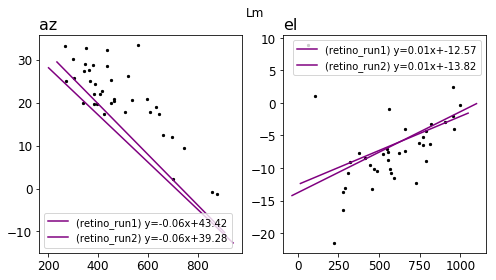

In [749]:
datakey = '20190525_JC084_fov1'

fig, axn = pl.subplots(1,2, figsize=(8,4))
for ax, cond in zip(axn.flat, ['az', 'el']):
    xname = 'ml_pos' if cond=='az' else 'ap_pos'
    yname = 'x0' if cond=='az' else 'y0'
    
    cell_locs = rfdf[rfdf['datakey']==datakey][xname].values
    rf_locs = rfdf[rfdf['datakey']==datakey][yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k')
  
    # Plot retino direction
    currvs = projdf[projdf['datakey']==datakey]
    for retinorun, g in currvs.groupby(['retinorun']):

        slope = float(g[g['cond']==cond]['coefficient'])
        intercept = float(g[g['cond']==cond]['intercept'])
        ax = abline(slope, intercept, ax=ax, label=True, label_prefix=retinorun)
        
   #ax.invert_yaxis()
    ax.set_title(cond, loc='left', size=16)
    
pl.suptitle(currvs['visual_area'].unique()[0])


## Plot each individaul session (retino fit, + cell positions vs. rf positions)

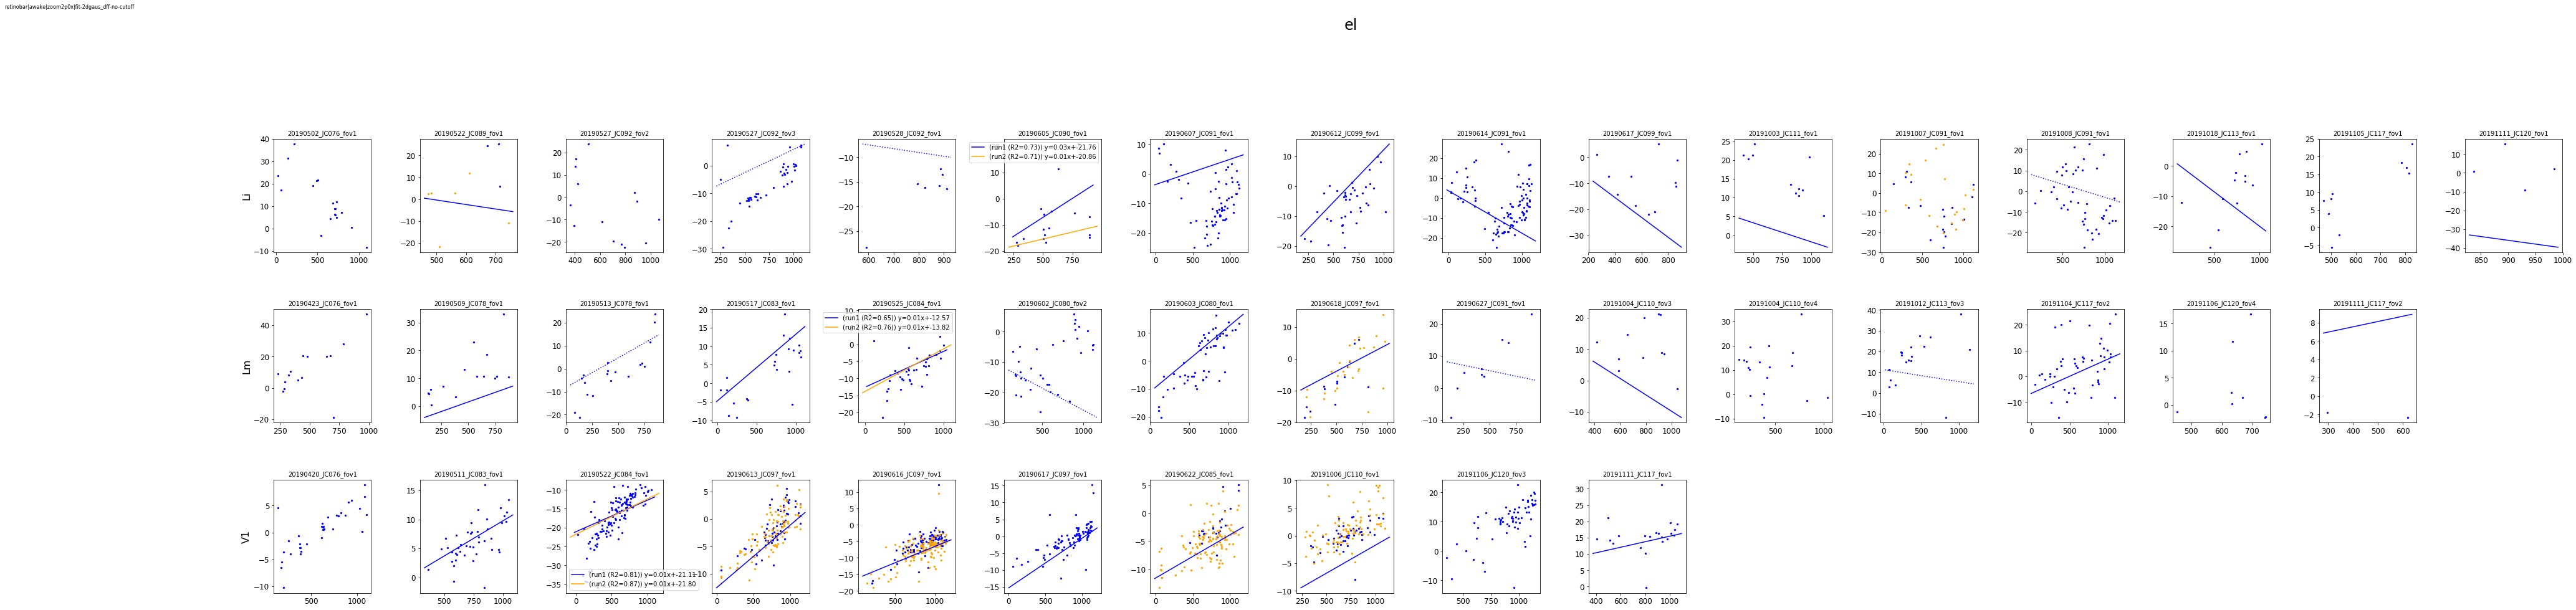

In [648]:
cond = 'el'
rep_colors=['blue', 'orange']

xname = 'ml_pos' if cond=='az' else 'ap_pos'
yname = 'x0' if cond=='az' else 'y0'
    
max_nfovs = int(r_df[['visual_area','datakey']].drop_duplicates().groupby(['visual_area']).count().max())

fig, axn = pl.subplots(3, max_nfovs, figsize=(60,15))
for ri, (visual_area, vdf) in enumerate(r_df.groupby(['visual_area'])):
    for ci, (datakey, ddf) in enumerate(vdf.groupby(['datakey'])):
        ax = axn[ri, ci]
        if ci==0:
            ax.set_ylabel(visual_area, fontsize=16)
        for col, (exp, edf) in zip(rep_colors, ddf.groupby(['experiment'])):

            # Plot RF positions vs. cell locs
            cell_locs = edf[xname].values
            rf_locs = edf[yname].values
            ax.scatter(cell_locs, rf_locs, marker='o', s=5, color=col)

        # Plot retino direction
        regdf_vs = projdf[projdf['datakey']==datakey]
        for col, (retinorun, g) in zip(rep_colors, regdf_vs.groupby(['retinorun'])):
            slope = float(g[g['cond']==cond]['coefficient'])
            intercept = float(g[g['cond']==cond]['intercept'])
            ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
            r2_v = float(g[g['cond']==cond]['R2'])
            label_prefix = '%s (R2=%.2f)' % (retinorun.split('_')[-1], r2_v) if len(regdf_vs)>2 else ''
            label = len(regdf_vs)>2
            ax = abline(slope, intercept, ax=ax, color=col,
                        label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title(datakey, fontsize=10)
    
    if ci < (max_nfovs-1):
        for ci in np.arange(ci+1, max_nfovs):
            axn[ri, ci].axis('off')
    
pl.subplots_adjust(left=0.1, wspace=0.5, hspace=0.5, right=0.95, top=0.8)
pl.suptitle(cond, fontsize=24)

label_figure(fig, data_id)

figname = 'retinogradient_v_rfpos_v_fovpos_%s__%s' % (cond, filter_str)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis','%s.svg' % figname))

In [603]:
gradients[gradients['datakey']=='20190607_JC091_fov1']

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,visual_area,abs_coef
0,0.539625,10.558528,0.041291,az,-13.840556,0.0,0.734592,JC091,20190607,FOV1_zoom2p0x,retino_run1,analysis002,20190607_JC091_fov1,Li,0.041291
1,0.955945,0.519029,0.008506,el,-3.669879,0.0,0.977724,JC091,20190607,FOV1_zoom2p0x,retino_run1,analysis002,20190607_JC091_fov1,Li,0.008506


In [646]:
gradients[gradients['datakey']==datakey]

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,visual_area,abs_coef
0,0.915193,1.467429,0.019115,az,6.461437,0.0,0.956657,JC084,20190522,FOV1_zoom2p0x,retino_run1,analysis002,20190522_JC084_fov1,V1,0.019115
1,0.814970,1.261910,0.008356,el,-21.107253,0.0,0.902757,JC084,20190522,FOV1_zoom2p0x,retino_run1,analysis002,20190522_JC084_fov1,V1,0.008356
0,0.950388,1.109767,0.017605,az,9.409270,0.0,0.974878,JC084,20190522,FOV1_zoom2p0x,retino_run2,analysis002,20190522_JC084_fov1,V1,0.017605
1,0.872690,1.153474,0.009370,el,-21.799416,0.0,0.934179,JC084,20190522,FOV1_zoom2p0x,retino_run2,analysis002,20190522_JC084_fov1,V1,0.009370


In [82]:
p_df

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r
0,0.972158,4.367112,0.111438,az,-47.168755,0.0,0.985981
1,0.415102,3.152030,-0.009017,el,5.196323,0.0,-0.644284


In [83]:
datakey = '20190607_JC091_fov1'
retinorun = 'retino_run1'

# p_df = projection_df[projection_df['datakey']==datakey]
# Load 1 fov to test sth
fpath = [p for p in proj_fit_paths if p[0]=='JC091' and p[1]=='20190607' and p[3]==retinorun][0][5]
with open(fpath, 'rb') as f:
    res = pkl.load(f)
print(res['regr_az'].coef_, res['regr_az'].intercept_)

p_df = res['regr_df'].copy()


#retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
#fpath = p_df[p_df['retinorun']==retinorun]['fpath'].unique()[0]
gpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(gpath, 'rb') as f:
    gresults = pkl.load(f)

(array([[ 0.11143814]]), array([-47.16875492]))


In [84]:
gresults.keys()

['el', 'az']

In [85]:
p_df

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r
0,0.972158,4.367112,0.111438,az,-47.168755,0.0,0.985981
1,0.415102,3.152030,-0.009017,el,5.196323,0.0,-0.644284


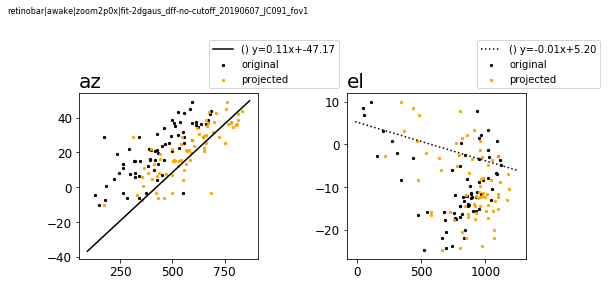

In [86]:
datakey = '20190607_JC091_fov1'
retinorun = 'retino_run1'
rfname = 'rfs10'

g = p_df.copy() #projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
edf = r_df[(r_df['datakey']==datakey) & (r_df['experiment']==rfname)]

fig, axn = pl.subplots(1,2, figsize=(8,4))
for ax, cond in zip(axn.flat, ['az', 'el']):
    xname = 'ml_pos' if cond=='az' else 'ap_pos'
    yname = 'x0' if cond=='az' else 'y0'

    # Plot RF positions vs. cell locs
    cell_locs = edf[xname].values
    rf_locs = edf[yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='original')

    proj_locs = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
                              for ap, ml in edf[['ap_pos', 'ml_pos']].values]))
    ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='orange', label='projected')

    # proj_locs = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
    #                           for ap, ml in edf[['ap_pos', 'ml_pos']].values]))
    # ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='red')

    # plot gradient line
    slope = float(g[g['cond']==cond]['coefficient'])
    intercept = float(g[g['cond']==cond]['intercept'])
    ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
    label_prefix = retinorun if len(g)>2 else ''
    label = True
    ax = abline(slope, intercept, ax=ax, color='k',
                label=label, label_prefix=label_prefix, ls=ls)
    ax.set_title(cond, loc='left', fontsize=20)
    
    ax.legend(bbox_to_anchor=(0.7, 1), loc='top')
    
pl.subplots_adjust(top=0.7, wspace=0.5)

label_figure(fig, '%s_%s' % (data_id, datakey))

In [628]:
edf.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,fx,fy,ratio_xy,theta_c,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
891,0.767913,24.021635,16.906345,0.057323,24.876325,-10.753185,JC084,0,20190522_JC084_fov1,rfs,...,10.205182,0.585638,1.420865,0.057323,345.675,150,19.0372,10,953.763,831.925
892,0.561637,36.760755,19.990691,6.066365,27.627541,-9.198699,JC084,1,20190522_JC084_fov1,rfs,...,15.276617,3.365187,1.838894,-0.216821,207.405,90,79.9562,42,892.844,970.195
893,0.585081,27.889204,21.404847,6.220339,17.433089,-11.532854,JC084,5,20190522_JC084_fov1,rfs,...,11.844317,0.745358,1.302939,-0.062847,202.796,88,196.083,103,776.717,974.804
894,0.852636,24.879592,20.229131,0.103731,23.867409,-11.367222,JC084,9,20190522_JC084_fov1,rfs,...,10.530152,1.096238,1.229889,0.103731,400.983,174,173.238,91,799.562,776.617
895,0.526608,17.091075,23.108701,1.607293,24.144343,-11.700484,JC084,10,20190522_JC084_fov1,rfs,...,0.358813,9.826941,0.739595,-1.534299,394.07,171,194.179,102,778.621,783.53


In [630]:
proj_ = [np.dot(np.array((ap, ml)), gresults['el']['vhat']) for ap, ml in edf[['ap_pos', 'ml_pos']].values]



[1265.2474336870805,
 1306.7746604873687,
 1220.4113895819639,
 1111.3053426323288,
 1099.6193022330513,
 1093.6652739832678,
 1056.9476933257663,
 1015.6602439137907,
 990.40668755527713,
 1006.5293870488546,
 1019.7771998236738,
 1021.1258367429371,
 1081.1799756229473,
 988.56073457136483,
 997.45181404798802,
 975.52605725282399,
 901.64686373724146,
 879.57901663789187,
 754.36803148270235,
 726.79906897816022,
 589.01519999303241,
 505.23375455400378,
 719.83386828155369,
 862.66716079778098,
 878.95859252757896,
 784.69765330435064,
 747.82022105464046,
 758.15762453465459,
 903.43953285708426,
 699.47876450594276,
 670.07272966149981,
 725.92998683552287,
 709.92273571409578,
 673.12522926049019,
 648.16473415435871,
 674.66924034800832,
 638.00494355457636,
 573.33653270003447,
 532.19117359224447,
 523.50434892788769,
 464.78996632312948,
 444.19508515920552,
 473.66328451172956,
 281.61057266015501,
 720.26901983812149,
 627.64977878653906,
 787.87448191950318,
 739.54190601

In [610]:
float(g[g['cond']==cond]['intercept'])

6.461437259218765

In [171]:
def plot_phase_map(array, zimg=None, cmap='hsv', vmin=-np.pi, vmax=np.pi, alpha=0.7,
                  plot_transparent=True, plot_smoothed=False, ax=None):
    
    norm = mcolors.Normalize(vmin, vmax)
    
    if ax is None:
        fig, ax = pl.subplots()

    if plot_transparent:
        if zimg is not None:
            ax.imshow(zimg, cmap='gray', alpha=0); ax.axis('off')
        ax.patch.set_visible(0)
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    else:
        ax.patch.set_visible(0)
        if zimg is not None:
            ax.imshow(zimg, cmap='gray'); ax.axis('off');
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    return ax

<IPython.core.display.Javascript object>


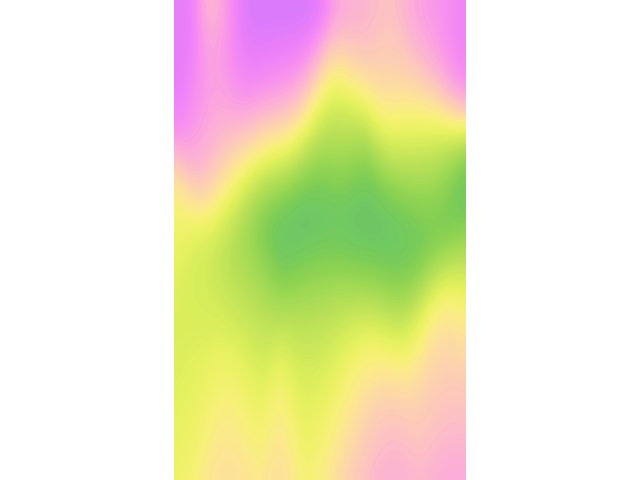

neuropil_absolute-azimuth_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [172]:

condition = 'azimuth'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

# Save legends

<IPython.core.display.Javascript object>


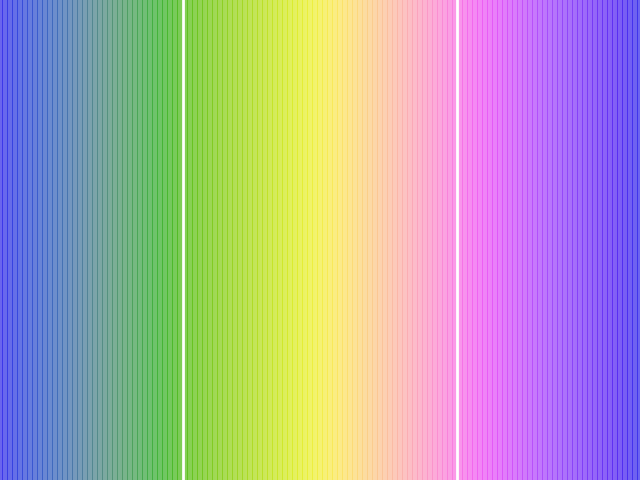

In [117]:
fig = pl.figure()

# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.

cbar1_orientation='horizontal'
cbar1_axes = [0, 0, 1, 1] #[0.31, 0.78, 0.1, 0.05]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

pl.savefig(os.path.join(outdir, 'legend_absolute-azimuth.png')) #% (figname, label_str)))


<IPython.core.display.Javascript object>


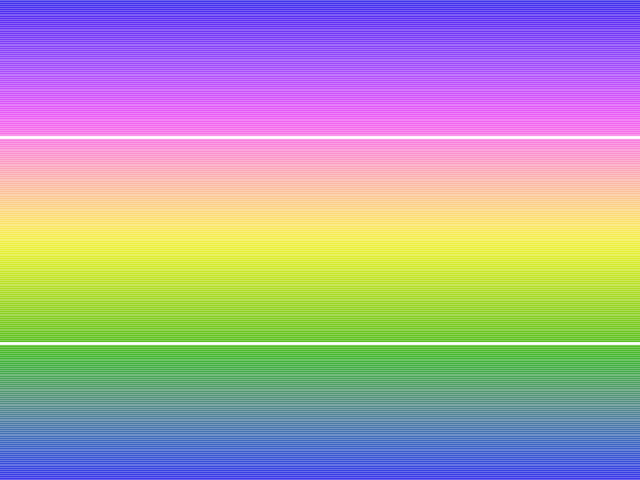

corrected_absolute-elevation_filter-allconds-magthr0.01_174cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [118]:
fig = pl.figure()

cbar2_orientation='vertical'
cbar2_axes = [0, 0, 1, 1] #[0.79, 0.78, 0.1, 0.05]

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)


#label_figure(fig, data_identifier)
pl.savefig(os.path.join(outdir, 'legend_absolute-elevation.png')) #% (figname, label_str)))

print(figname)